## Work out how the modules for non-ML models should work

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
import sys
sys.path.append('../modules/')

In [4]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-02-09 19:30:18.553700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-09 19:30:18.571889: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-09 19:30:18.577437: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# We need one place to save all the experiment relevant info.  
experiment_config= {'simulation_names':['DG'], 
                    'filter_scales':['50','100','200','400'],
                    #'filter_scales':['100'],
                    'window_size':3, 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, including those used as coefficients
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          'mag_nabla_h_widened',
                                          'filter_scale', 
                                          'mag_nabla_u_widened',
                                          'uphp_rotated',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated',
                                          'uphp_rotated_nondim',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated_nondim'], 
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim'],
                    
                    'output_channels' :  ['uphp_rotated',
                                          'vphp_rotated'],
                    
                    'coeff_channels'  : ['filter_scale','filter_scale','mag_nabla_h_widened', 'mag_nabla_u_widened'], 

                    'extra_channels'   : [],

                    'use_coeff_channels': True,

                    'all_time_range': slice(-256,None),
                    'train_time_range': slice(0, 128),
                    'test_time_range' : slice(-128, None),
                    'eval_time_range' : slice(-256, -128),
                    'num_train_batches': 8, 
                    'num_test_batches' : 8, 

                    'num_inputs': 55, 
                    'network_shape': [36, 36, 2],

                    'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_data_size/window_3/'
                    
            }
experiment_config['num_inputs'] = len(experiment_config['input_channels']) * experiment_config['window_size']**2

In [6]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names =experiment_config['simulation_names'], 
                             filter_scales    =experiment_config['filter_scales'], 
                             window_size      = experiment_config['window_size'], 
                             time_sel         = experiment_config['all_time_range'],
                             single_layer_mask_flag=True
                             )

In [7]:
# Randomly just picked with the case where we check the impact of training data size on skill
train_sets = {'model1' : {'train_time_range': slice(0,32), 'num_train_batches':2}, 
             'model2' : {'train_time_range': slice(0,128), 'num_train_batches':8},
             'model3' : {'train_time_range': slice(0,512), 'num_train_batches':32},
             'model4' : {'train_time_range': slice(0,2048), 'num_train_batches':128}, 
              'model5': {'train_time_range': slice(0,3400), 'num_train_batches':196}  
               }
for train_keys in train_sets.keys(): 
    train_sets[train_keys]['save_dir'] = experiment_config['exp_ckpt_save_dir'] + train_keys


In [8]:
# Load in and get the models ready to evaluate
for model_key in ['model3']:
    print(train_sets[model_key]['save_dir'])
    train_sets[model_key]['eval_sys'] = evaluation.EvalSystem(simulation_data=DT,
                                 input_channels=experiment_config['input_channels'],
                                 output_channels=experiment_config['output_channels'], 
                                 coeff_channels=experiment_config['coeff_channels'], 
                                 extra_channels=experiment_config['extra_channels'],
                                 use_norm_factors=True,
                                 eval_time_slice=experiment_config['eval_time_range'], 
                                 num_inputs=experiment_config['num_inputs'], 
                                 shape=experiment_config['network_shape'], 
                                 ckpt_dir=train_sets[model_key]['save_dir'],
                                 use_coeff_channels=experiment_config['use_coeff_channels'])
    train_sets[model_key]['eval_sys'].read_ann_regression_model()
    train_sets[model_key]['eval_sys'].read_eval_data()
    train_sets[model_key]['eval_sys'].predict()

/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_data_size/window_3/model3


In [10]:
eval_sys = train_sets[model_key]['eval_sys']

In [11]:
eval_sys.add_gradient_model_variables()

In [69]:
eval_sys.add_gent_mcwilliams_variables()

In [70]:
ds_sim = eval_sys.simulation_data.simulation_data['DG']['100']

In [80]:
ds = eval_sys.eval_datatree.ml_dataset['DG']['100']

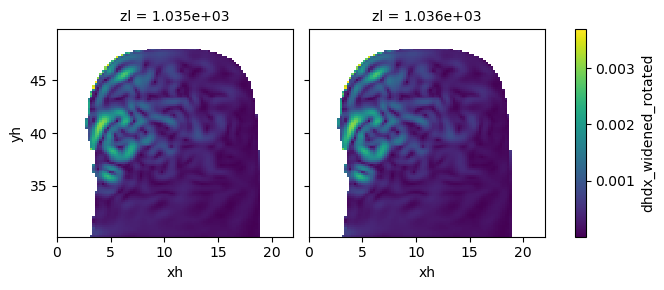

In [81]:
ds_sim.dhdx_widened_rotated.isel(Time=-1, Xn=1, Yn=1).plot(col='zl')

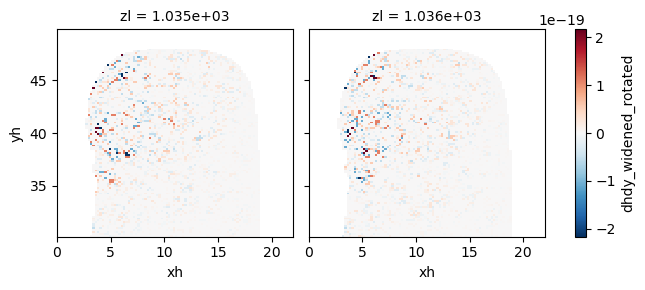

In [82]:
ds_sim.dhdy_widened_rotated.isel(Time=-1, Xn=1, Yn=1).plot(col='zl')

In [83]:
ds.kappa_gent_mcwilliams.values

array(92.2860493)

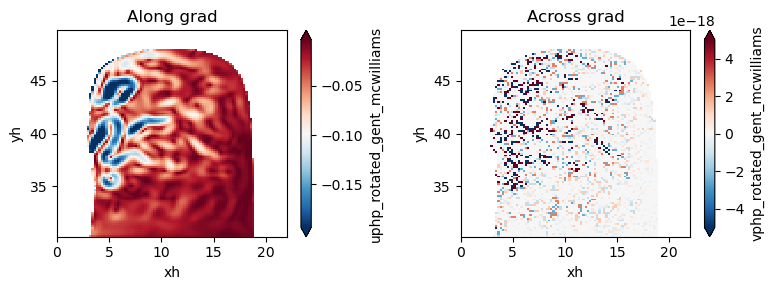

In [84]:

zl = 1

plt.figure(figsize=(8, 3))  # Correct way to set figure size

plt.subplot(121)
ds.uphp_rotated_gent_mcwilliams.isel(Time=-1, zl=zl).plot(robust=True, cmap='RdBu_r')
plt.title("Along grad")

plt.subplot(122)
ds.vphp_rotated_gent_mcwilliams.isel(Time=-1, zl=zl).plot(robust=True, cmap='RdBu_r')
plt.title("Across grad")



plt.tight_layout()

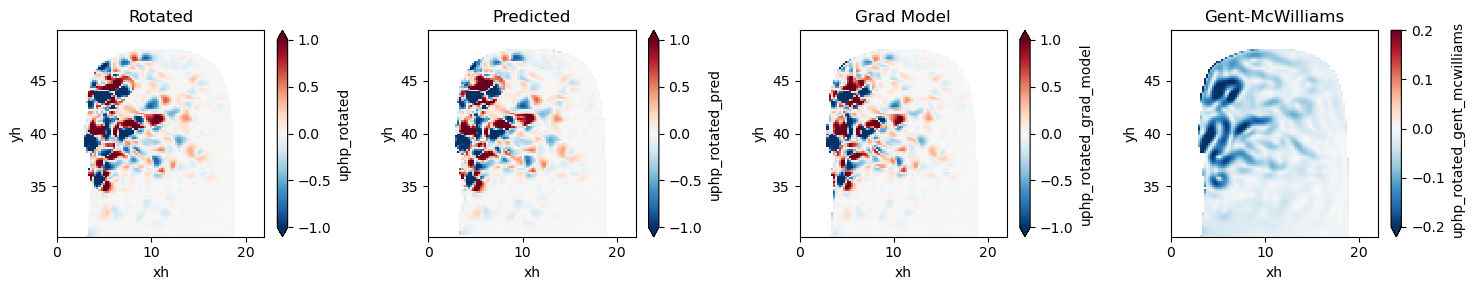

In [89]:
import matplotlib.pyplot as plt

zl = 0
vmin = -1
vmax = 1
plt.figure(figsize=(15, 3))  # Correct way to set figure size

plt.subplot(141)
ds.uphp_rotated.isel(Time=-1, zl=zl).plot(vmin=vmin, vmax=vmax, cmap='RdBu_r')
plt.title("Rotated")

plt.subplot(142)
ds.uphp_rotated_pred.isel(Time=-1, zl=zl).plot(vmin=vmin, vmax=vmax, cmap='RdBu_r')
plt.title("Predicted")

plt.subplot(143)
ds.uphp_rotated_grad_model.isel(Time=-1, zl=zl).plot(vmin=vmin, vmax=vmax, cmap='RdBu_r')
plt.title("Grad Model")

plt.subplot(144)
ds.uphp_rotated_gent_mcwilliams.isel(Time=-1, zl=zl).plot(vmin=vmin/5, vmax=vmax/5, cmap='RdBu_r')
plt.title("Gent-McWilliams")

plt.tight_layout()

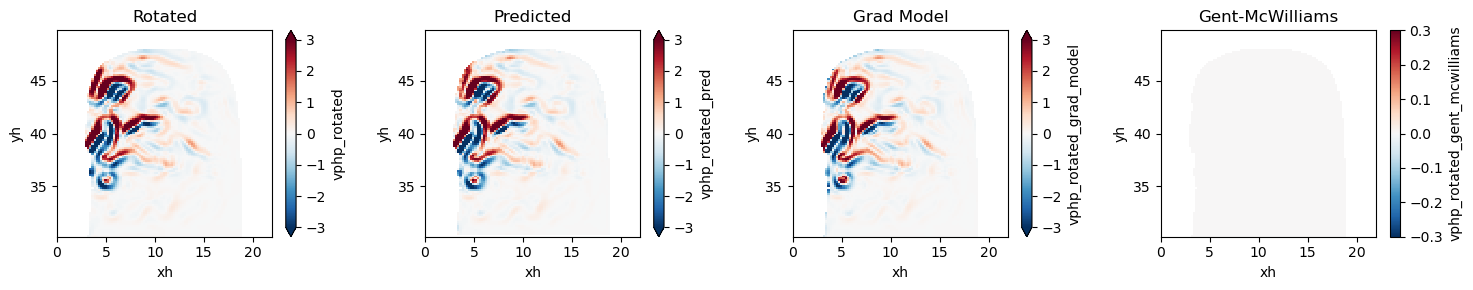

In [91]:
import matplotlib.pyplot as plt

zl = 0
vmin = -3 
vmax = 3
plt.figure(figsize=(15, 3))  # Correct way to set figure size

plt.subplot(141)
ds.vphp_rotated.isel(Time=-1, zl=zl).plot(vmin=vmin, vmax=vmax, cmap='RdBu_r')
plt.title("Rotated")

plt.subplot(142)
ds.vphp_rotated_pred.isel(Time=-1, zl=zl).plot(vmin=vmin, vmax=vmax, cmap='RdBu_r')
plt.title("Predicted")

plt.subplot(143)
ds.vphp_rotated_grad_model.isel(Time=-1, zl=zl).plot(vmin=vmin, vmax=vmax, cmap='RdBu_r')
plt.title("Grad Model")

plt.subplot(144)
ds.vphp_rotated_gent_mcwilliams.isel(Time=-1, zl=zl).plot(vmin=vmin/10, vmax=vmax/10, cmap='RdBu_r')
plt.title("Gent-McWilliams")

plt.tight_layout()

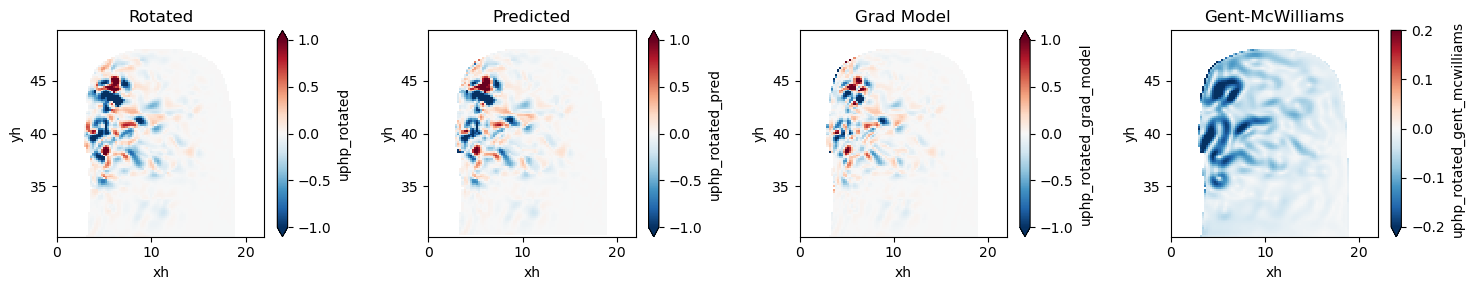

In [92]:
import matplotlib.pyplot as plt

zl = 1
vmin = -1
vmax = 1
plt.figure(figsize=(15, 3))  # Correct way to set figure size

plt.subplot(141)
ds.uphp_rotated.isel(Time=-1, zl=zl).plot(vmin=vmin, vmax=vmax, cmap='RdBu_r')
plt.title("Rotated")

plt.subplot(142)
ds.uphp_rotated_pred.isel(Time=-1, zl=zl).plot(vmin=vmin, vmax=vmax, cmap='RdBu_r')
plt.title("Predicted")

plt.subplot(143)
ds.uphp_rotated_grad_model.isel(Time=-1, zl=zl).plot(vmin=vmin, vmax=vmax, cmap='RdBu_r')
plt.title("Grad Model")

plt.subplot(144)
ds.uphp_rotated_gent_mcwilliams.isel(Time=-1, zl=zl).plot(vmin=vmin/5, vmax=vmax/5, cmap='RdBu_r')
plt.title("Gent-McWilliams")

plt.tight_layout()